# Sunspot Grouping

In [63]:
from module import getUmbraPenumbra, toSunpyMap

map = toSunpyMap('data/L2/imoa_03933_l2_20240323_13052647_emi1.fts.bz2')

umbra, penumbra = getUmbraPenumbra(map)

Group :

In [64]:
import astropy.units as u
import numpy as np
import cv2 as cv


threshold = 0.05

n_labels, labels, stats, centroids = cv.connectedComponentsWithStats(umbra | penumbra, connectivity=8)

unique_labels = np.arange(1,n_labels)

for label in unique_labels:
    point = map.pixel_to_world(centroids[label][0]*u.pixel, centroids[label][1]*u.pixel)
    
    for other_label in unique_labels:
        if label==other_label:
            continue
        
        other_point = map.pixel_to_world(centroids[other_label][0]*u.pixel, (centroids[other_label][1])*u.pixel)
        
        if point.separation(other_point).value < threshold:
            labels[labels==other_label]=label
            unique_labels = unique_labels[unique_labels!=other_label]


for idx, label in enumerate(np.unique(labels)):
    labels[labels==label]=idx

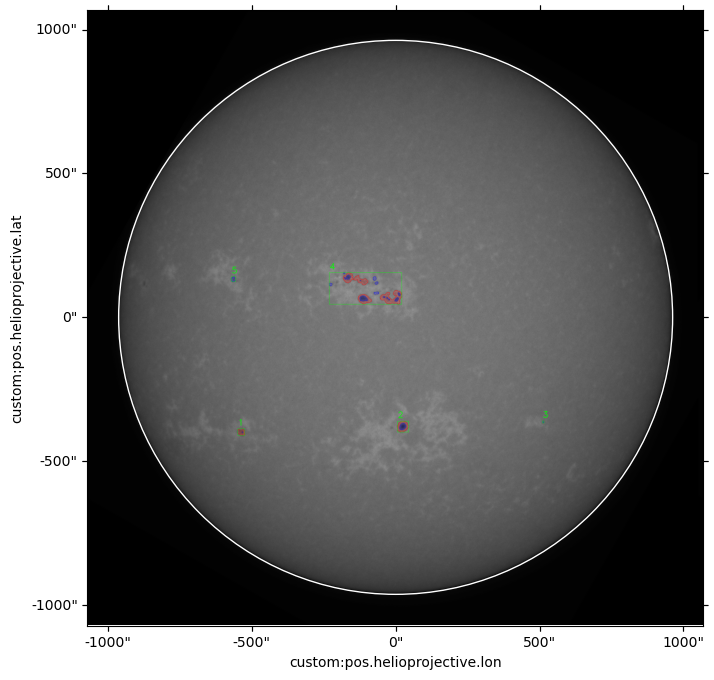

In [65]:
import matplotlib.pyplot as plt
from module import drawSunspots


img = drawSunspots(map)

font = cv.FONT_HERSHEY_DUPLEX

fontScale = 1

color = (0, 255, 0) 

thickness = 1

unique_labels = np.unique(labels)
for label in unique_labels[1:]:
    x,y,w,h = cv.boundingRect((labels==label).astype(np.uint8))
    cv.rectangle(img, (x,y,w,h),(0,255,0),1)
    img = cv.putText(img, f'{label}', (x, y+h+10), font,  
                fontScale, color, thickness, cv.LINE_AA, True)
   
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=map)
plt.imshow(img, origin='lower');
map.draw_limb(axes=ax)

plt.show()

In [66]:
from skimage import measure

regions = measure.regionprops(labels)

group_centroids = np.array([[r.centroid[1], r.centroid[0]] for r in regions]).astype(np.uint16)

# Adding centroid for label 0
group_centroids = np.insert(group_centroids, 0, [1024, 1024], axis=0)

print(group_centroids)

[[1024 1024]
 [ 512  641]
 [1049  659]
 [1516  674]
 [ 947 1109]
 [ 486 1148]]


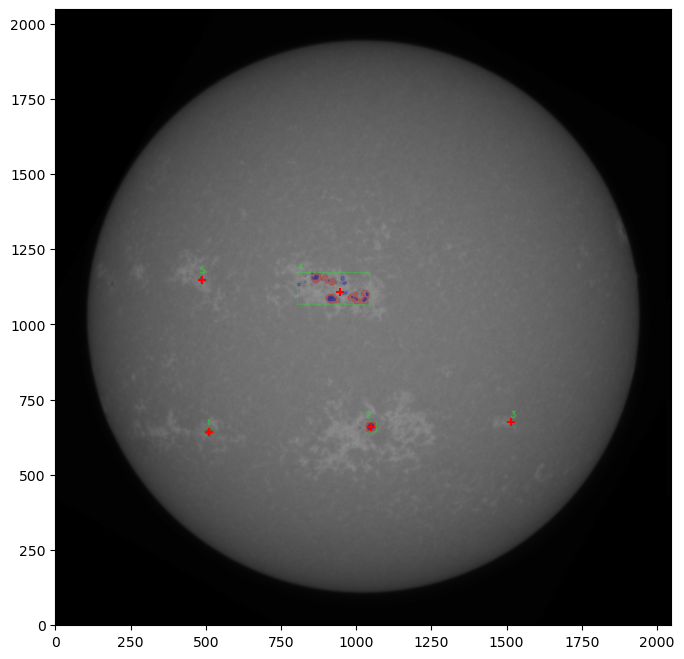

In [67]:
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray',origin='lower')

for centroid in group_centroids[1:]:
    plt.scatter(centroid[0], centroid[1], marker='+', color='red')

plt.show()